In [40]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils import gen_batches, shuffle
from scikitplot.metrics import plot_roc, plt
from tqdm.notebook import tqdm

from nya_ml.models.skolkovoInstitute_russian_toxicity_classifier import RuToxicityClassifier
from nya_ml_research.config import DATA_PATH

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
model = RuToxicityClassifier.load()

In [12]:
from torchviz import make_dot

inputs = model.tokenizer('всем привет', max_length=512, padding=True, truncation=True, return_tensors='pt')
outputs = model.model(**inputs)

make_dot(
    outputs.logits,
    params=dict(list(model.model.named_parameters()))
).render("rnn_torchviz", format="png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.981254 to fit


'rnn_torchviz.png'

In [55]:
df = pd.read_csv(DATA_PATH / 'raw' / 'toxic' / 'kaggle-ru-toxic-comments.csv', names=['text', 'label'], skiprows=1)
# df = pd.read_csv(DATA_PATH / 'raw' / 'toxic' / 'kaggle-ru-toxic-social-network.csv', names=['text', 'label'])

In [56]:
df.head(10)

,text,label
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [57]:
shuffle_df = shuffle(df)

In [58]:
# y_pred = list(tqdm(map(predict, df.comment)))
y_pred = []
for batch in tqdm(gen_batches(len(shuffle_df.text), 64), total=int(len(shuffle_df.text) / 64)):
    pred = model._predict(shuffle_df.text[batch].values.tolist())[:, 1].numpy()
    y_pred.append(pred)


  0%|          | 0/225 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [59]:
y_pred_flatten = np.concatenate(y_pred)
y_true = shuffle_df.label[:len(y_pred_flatten)]
y_pred_2_classes = np.vstack([1 - y_pred_flatten, y_pred_flatten]).T

In [60]:
len(y_pred_flatten)

8064

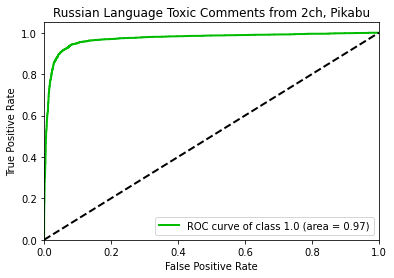

In [62]:
roc = plot_roc(
    y_true, y_pred_2_classes,
    title='Russian Language Toxic Comments from 2ch, Pikabu',
    plot_macro=False, plot_micro=False, classes_to_plot=1
)

In [64]:
roc.get_figure().savefig('roc_curve_kaggle_2ch_pikabu_toxic_skolkovo.png')

In [68]:
roc_curve(y_true, y_pred_flatten)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.86393290e-04,
        1.86393290e-04, 1.86393290e-04, 1.86393290e-04, 1.86393290e-04,
        1.86393290e-04, 1.86393290e-04, 1.86393290e-04, 1.86393290e-04,
        1.86393290e-04, 1.86393290e-04, 1.86393290e-04, 3.72786580e-04,
        3.72786580e-04, 3.72786580e-04, 3.72786580e-04, 3.72786580e-04,
        3.72786580e-04, 3.72786580e-04, 3.72786580e-04, 5.59179870e-04,
        5.59179870e-04, 7.45573159e-04, 7.45573159e-04, 7.45573159e-04,
        7.45573159e-04, 9.31966449e-04, 9.31966449e-04, 1.11835974e-03,
        1.11835974e-03, 1.30475303e-03, 1.30475303e-03, 1.30475303e-03,
        1.30475303e-03, 1.30475303e-03, 1.30475303e-03, 1.30475303e-03,
        1.49114632e-03, 1.49114632e-03, 1.49114632e-03, 1.49114632e-03,
        1.67753961e-03, 1.67753961e-03, 1.86393290e-03, 1.86393290e-03,
        1.86393290e-03, 1.86393290e-03, 1.86393290e-03, 1.86393290e-03,
        2.05032619e-03, 2.05032619e-03, 2.23671948e-03, 2.236719

In [71]:
print(classification_report(y_true, y_pred_flatten.round(decimals=1).astype(int)))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91      5365
         1.0       0.97      0.63      0.76      2699

    accuracy                           0.87      8064
   macro avg       0.90      0.81      0.83      8064
weighted avg       0.88      0.87      0.86      8064



In [74]:
print(classification_report(y_true, list(map(lambda f: (f > 0.85) and 1 or 0, y_pred_flatten))))

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      5365
         1.0       0.95      0.79      0.86      2699

    accuracy                           0.92      8064
   macro avg       0.93      0.88      0.90      8064
weighted avg       0.92      0.92      0.91      8064



In [27]:
import os
import django

os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'nya_app.nyaural_nyatworks.settings')
django.setup()

from nya_app.nyaural_nyatworks.models import Report, Tag


ModuleNotFoundError: No module named 'nyaural_nyatworks'

In [ ]:
md = """
# RuBert для классификации токсичных текстов от Сколковского института
## Тестирование на датасетах
### Russian toxic comments form 2ch, Pikabu (Kaggle)
### Roc curve
![](roc_curve_kaggle_2ch_pikabu_toxic_skolkovo.png)
"""

In [ ]:
bert_rep = Report(
    title='RuBert SkolkovoInstitute',
    text=md,
    tags=[
        Tag('toxic', grad=1),
        Tag('best', grad=0),
    ]
)